# 🌿Cassava Leaf Disease Classification

---
#### Overview
*  In Africa cassava is a key food but viral diseases are major sources of poor yields. With the help of data science, it may be possible to identify common diseases so they can be treated.


<img src=https://www.healthbenefitstimes.com/9/uploads/2016/03/Cassava-Leaf.png width="300">


* In this competition, we introduce a dataset of 21,367 labeled images
* Your task is to classify each cassava image into four disease categories or a fifth category indicating a healthy leaf.
---
#### Data

[train/test]_images the image files. The full set of test images will only be available to your notebook when it is submitted for scoring. Expect to see roughly 15,000 images in the test set.



##### train.csv

* __image_id__ : the image file name.
* __label__ : the ID code for the disease.

##### sample_submission.csv 
A properly formatted sample submission, given the disclosed test set content.

* __image_id__ :  the image file name.
* __label__ : the predicted ID code for the disease.



[train/test]_tfrecords the image files in tfrecord format.


label_num_to_disease_map.json The mapping between each disease code and the real disease name.

---
#### Evaluation
Submissions will be evaluated based on their [categorization accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy).
<img src=https://t1.daumcdn.net/cfile/tistory/99DC064C5BE056CE10  width="300">

---

[Competition Link](https://www.kaggle.com/c/cassava-leaf-disease-classification/overview/timeline)

# Import Library (step.01)

In [1]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import timm

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics
import warnings
import cv2
import pydicom
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

# Setting

In [2]:
CFG = {
    'fold_num': 5,
    'seed': 719,
    'model_arch': 'tf_efficientnet_b4_ns',
    'img_size': 256,
    'epochs': 10,
    'train_bs': 16,
    'valid_bs': 32,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay':1e-6,
    'num_classes' : 5,
    'num_workers': 0,
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0'
}

In [3]:
CFG['num_classes']

5

In [4]:
# CUDA 장치를 사용하도록 설정합니다:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Load Data

In [5]:
# get train data
path = 'D:/data/cassava-leaf-disease-classification/'
train = pd.read_csv(path + 'train.csv')
print(train.shape)
train.head()

(21397, 2)


image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [6]:
# get submission data
submission = pd.read_csv(path + 'sample_submission.csv')
print(submission.shape)
submission.head()

(1, 2)


image_id  label
0  2216849948.jpg      4

<function matplotlib.pyplot.show(*args, **kw)>

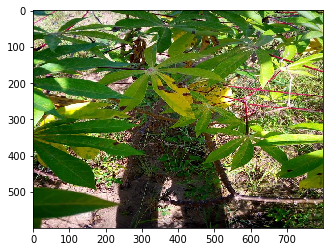

In [7]:
# get image data
def get_img(image_path):
    im_bgr = cv2.imread(image_path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

image_train_path = 'D:/data/cassava-leaf-disease-classification/train_images/'
image_test_path = 'D:/data/cassava-leaf-disease-classification/test_images/'

img_eg = get_img('D:/data/cassava-leaf-disease-classification/train_images/1000015157.jpg')
plt.imshow(img_eg)
plt.show

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

In [9]:
class CassavaDataset(Dataset):
    def __init__(self, df, transform = None, test = False):
        self.df = df
        self.transform = transform
        self.test = test
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        label = self.df.label.values[idx]
        img = self.df.image_id.values[idx]
        
        if self.test == False:
            img_path = image_train_path + img
        else:
            img_path = image_test_path + img
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = transforms.ToPILImage()(image)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지입니다. 이를 [-1, 1]의 범위로 정규화된 Tensor로 변환합니다.

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((CFG['img_size'],CFG['img_size'])),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

valid_transform = transforms.Compose([
    transforms.Resize((CFG['img_size'],CFG['img_size'])),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])


validset      = CassavaDataset(submission, transform = valid_transform, test = True)
valid_loader  = DataLoader(validset, batch_size = CFG['valid_bs'], shuffle = False, num_workers = CFG['num_workers'])

In [11]:
class AverageMeter:
    """
    Computes and stores the average and current value
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [12]:
def train_model(model, epoch):
    model.train() 
    
    losses = AverageMeter()
    accs = AverageMeter()
    
    tk = tqdm(train_loader, total=len(train_loader), position=0, leave=True)
    for idx, (imgs, labels) in enumerate(tk):
        imgs_train, labels_train = imgs.to(device).float(), labels.to(device).long()
        output_train = model(imgs_train)

        loss = criterion(output_train, labels_train)
        
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step() 
        
        accs.update((output_train.argmax(1)==labels_train).sum().item()/imgs_train.size(0),imgs_train.size(0))
        losses.update(loss.item(), imgs_train.size(0))

        tk.set_postfix(loss=losses.avg,acc=accs.avg)
        
    return losses.avg


def test_model(model):    
    model.eval()
    
    losses = AverageMeter()
    accs = AverageMeter()
    
    with torch.no_grad():
        tk = tqdm(val_loader, total=len(val_loader), position=0, leave=True)
        for idx, (imgs, labels) in enumerate(tk):
            imgs_valid, labels_valid = imgs.to(device).float(), labels.to(device).long()
            output_valid = model(imgs_valid)
            
            loss = criterion(output_valid, labels_valid)

            losses.update(loss.item(), imgs_valid.size(0))
            accs.update((output_valid.argmax(1)==labels_valid).sum().item()/imgs_valid.size(0),imgs_valid.size(0))
            
            tk.set_postfix(loss=losses.avg,acc=accs.avg)

            
    return losses.avg,accs.avg

In [13]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [14]:
train_df, val_df = train_test_split(train,test_size=0.2,stratify=train.label)

trainset = CassavaDataset(train_df,transform=train_transform)
train_loader = DataLoader(trainset, batch_size = CFG['train_bs'], shuffle=True, num_workers = CFG['num_workers'])

valset = CassavaDataset(val_df, transform = valid_transform)
val_loader = DataLoader(valset, batch_size = CFG['valid_bs'], shuffle=False, num_workers = CFG['num_workers'])

model = timm.create_model('tf_efficientnet_b0_ns', pretrained=True, num_classes =  CFG['num_classes'] )
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=CFG['lr'], weight_decay=0)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, \
                                                       patience=1, verbose=True, min_lr=1e-5)

best_acc = 0
n_epochs = 10

for epoch in range(n_epochs):
    train_loss = train_model(model, epoch)
    val_loss, acc = test_model(model)

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'weight.pt')

    print('current_val_acc:', acc, 'best_val_acc:', best_acc)

    scheduler.step(acc)

100%|██████████| 134/134 [01:26<00:00,  1.55it/s, acc=0.804, loss=0.54] 


current_val_acc: 0.8037383177570093 best_val_acc: 0.8037383177570093


100%|██████████| 134/134 [01:20<00:00,  1.67it/s, acc=0.822, loss=0.498]


current_val_acc: 0.8217289719626168 best_val_acc: 0.8217289719626168


100%|██████████| 134/134 [01:20<00:00,  1.65it/s, acc=0.826, loss=0.511]


current_val_acc: 0.8259345794392523 best_val_acc: 0.8259345794392523


100%|██████████| 134/134 [01:21<00:00,  1.65it/s, acc=0.821, loss=0.555]


current_val_acc: 0.8214953271028037 best_val_acc: 0.8259345794392523


100%|██████████| 134/134 [01:21<00:00,  1.64it/s, acc=0.828, loss=0.581]


current_val_acc: 0.827803738317757 best_val_acc: 0.827803738317757


100%|██████████| 134/134 [01:21<00:00,  1.64it/s, acc=0.825, loss=0.636]


current_val_acc: 0.8245327102803738 best_val_acc: 0.827803738317757


100%|██████████| 134/134 [01:20<00:00,  1.67it/s, acc=0.823, loss=0.695]


current_val_acc: 0.8226635514018692 best_val_acc: 0.827803738317757
Epoch     7: reducing learning rate of group 0 to 5.0000e-05.


100%|██████████| 134/134 [01:19<00:00,  1.69it/s, acc=0.824, loss=0.698]


current_val_acc: 0.8238317757009346 best_val_acc: 0.827803738317757


100%|██████████| 134/134 [01:20<00:00,  1.67it/s, acc=0.84, loss=0.694] 


current_val_acc: 0.8399532710280374 best_val_acc: 0.8399532710280374


100%|██████████| 134/134 [01:19<00:00,  1.68it/s, acc=0.831, loss=0.747]


current_val_acc: 0.8313084112149532 best_val_acc: 0.8399532710280374


In [25]:
# 모델 저장하기
torch.save(model.state_dict(), path + 'weight.pt')

In [26]:
test_pred = []

with torch.no_grad():
    for i, data in enumerate(tqdm(valid_loader, position=0, leave=True)):
        images, _ = data
        images = images.to(device)

        pred = model(images)

        pred = pred.argmax(1).cpu().detach().numpy().astype('int')

        test_pred.extend(pred)

submission.label = test_pred
submission.to_csv(path + 'submission_12_14.csv',index=False)

100%|██████████| 1/1 [00:00<00:00, 31.26it/s]
